In [ ]:
!pip install spotipy

     |████████████████████████████████| 63 kB 490 kB/s 
     |████████████████████████████████| 138 kB 11.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# Analyzing Data on Popular Music using Spotify
### by Tanaya Jha, Benjamin Rohd, and Adam Witiak
***
This project is a way to use what we learned about data science and apply it to an interest all of us have in common, music. We learned about Spotify's Web API and wanted to explore the various audio features they collect about each song and how they interact with measures of popularity, genre, and year, and whether there is a meaningful relationship between these factors and Spotify's audio features.


## Step 1: Reading in Data
First things first, we need to get a dataset. We found a set on [Kaggle](https://www.kaggle.com/) which contains the [Billboard Top 100](https://www.kaggle.com/datasets/dhruvildave/billboard-the-hot-100-songs?resource=download) for every week since 1958. To handle this data, we will need a few libraries:
1. [Pandas](https://pandas.pydata.org/), to store the data as a DataFrame, a 2-D array-like structure. Pandas also has other useful methods to handle data.
2. os, to store and read files, as well as set environment variables. We will need this later.

After downloading the file _charts.csv_ from Kaggle, use the Pandas function [read_csv()](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) to put it into a DataFrame.

In [ ]:
import pandas as pd
import os

# Read in data
data = pd.read_csv('charts.csv')

# Get data dimensions
print('Shape of dataset (number of entries vs. # of columns):', data.shape)

# Show a few example entries
data.head()

Shape of dataset (number of entries vs. # of columns): (330087, 7)


,date,rank,song,artist,last-week,peak-rank,weeks-on-board
0,2021-11-06,1,Easy On Me,Adele,1.0,1,3
1,2021-11-06,2,Stay,The Kid LAROI & Justin Bieber,2.0,1,16
2,2021-11-06,3,Industry Baby,Lil Nas X & Jack Harlow,3.0,1,14
3,2021-11-06,4,Fancy Like,Walker Hayes,4.0,3,19
4,2021-11-06,5,Bad Habits,Ed Sheeran,5.0,2,18


Now that we've read in the data, we can take a look at the different fields available to us. 
1. Date, the current week.
1. Rank, a song's ranking in the top 100.
1. Song, the song title.
1. Artist, who made the song. _Note: there may be multiple artists._
1. Last week, which was the ranking of the song in the previous week.
1. Peak rank, the highest rank in the top 100 the song has achieved.
1. Weeks on board, the number of weeks the song has stayed on the chart.

In total, we have 330,087 entries in the DataFrame.

## Step 2: Scraping and Refining from Spotify using SpotiPy
This data is great, but we want to get data on the songs themselves. Luckily, Spotify has a lot of useful data on music. Traits such as danceability, energy, instrumentalness, and loudness are calculated on each song and are accessible via a URI. This URI is unique to each song. _(You can read more about Spotify's audio features [here](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features).)_

To access the Spotify API, we use [SpotiPy](https://spotipy.readthedocs.io/en/2.19.0/#), a python library specifically crafted for interacting with Spotify. It handles all the backend of data requests, token refreshing, and other caveats then wraps everything in methods. To use it, you need a Spotify developer project, which can be created using [this tutorial](https://medium.com/@maxtingle/getting-started-with-spotifys-api-spotipy-197c3dc6353b). SpotiPy requires that certain tokens are set as environment variables.

TODO: remove client id and client secret id

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Set environment variables
os.environ["SPOTIPY_CLIENT_ID"] = "7f287679297447909a88fffe9fbeeede"
os.environ["SPOTIPY_CLIENT_SECRET"] = "51d3986a7ab34179ae6f30b16882c7db"

# Create spotify object
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

For each of the songs in our DataFrame, we need to:
1. Search the song on Spotify, to get the song URI.
2. Use that URI to get the audio features of the song.

We created a function called get_song_data to accomplish this, then applied it to every row of the DataFrame using Pandas' [apply()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) method.

In [ ]:
def get_song_data(row):  
    # Pull out each row's song and artist name
    song = row['song']
    artist = row['artist']
    
    # Will be filled with the URI and audio features
    data_list = []
    
    # Search for the song on Spotify: exactly like a user would do when using the actual app
    res1 = sp.search(q='track:'+song+' artist:'+artist[:5],type='track')['tracks']['items']
    
    # Check if a song is returned from the search
    if len(res1) == 0: # if no song found:
        uri = pd.NA
        for i in range(0,10): # Create a 10 feature vector of NA's
            data_list.append(pd.NA)
    else: # if a song is found:
        # Extract URI
        uri = res1[0]['uri']
        
        # From the URI, get the song's audio features
        res2 = sp.audio_features(uri)[0] # Create a 10 feature vector of all the features (including URI)
        
        # Return audio features
        data_list=[uri, res2['danceability'], res2['energy'], res2['loudness'], res2['speechiness'], res2['acousticness'], res2['instrumentalness'], res2['liveness'], res2['valence'], res2['tempo']]
    return data_list

When we run this code thousands of times for every song, we are relying on the fact that Spotify's API does not return any bad requests that would stop our code from running. To circumvent this issue, we split the data into chunks (so we do not lose all our progress if something goes wrong) and use error handling to restart our code.

In [ ]:
'''
    chunk: Splits a DataFrame into chunks of a certain size.
    
    Parameters:
        df: the DataFrame to be split.
        chunk_size: the requested size of each chunk. Default: 1000
        
    Returns: a list of DataFrames of length chunk_size. The last DataFrame may be shorter than chunk_size.
'''

def chunk(df, chunk_size = 1000):
    df_chunks = []

    for i in range(int(df.shape[0] / chunk_size)+1):
        df_chunks.append(df.iloc[(i * chunk_size):((i+1) * chunk_size),:])
        
    return df_chunks

The next chunk of code is slightly bulky so here's an explanation:

The initial block with for loops checks which chunks have already been run through the algorithm. It makes sure that if we run this code again, we are not getting the song URIs for songs we have already seen.

The method getAudio is where most of the magic happens. It loops through the chunks, gets the URIs and audio features, stores it in new columns of each dataFrame, and then stores it in a data folder specified by the data_folder variable. The except statement restarts the program if something goes wrong (i.e., Spotify API times out).

In [ ]:
import re
curr_num = -1
data_folder = "./data_2017"

# Check what files have been created so far
for root, dirs, files in os.walk(data_folder, topdown=False):
    for name in files:
        
        # If a data file is found, get its number
        r = re.search('^data(\d{1,2})',name)
        if r != None and int(r.group(1)) > curr_num:
            # Update the current number
            curr_num = int(r.group(1))
            
print(curr_num)
            
def getAudio(data, num):
    try:
        # Loop through chunks
        for i,df in enumerate(data):
            
            # If the file for that chunk has not been created
            if (i > num):
                # Apply get_song_data to each song, create new columns
                df[['uri', 'danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness', 'valence', 'tempo']] = df.apply(get_song_data,result_type='expand', axis=1)
                
                # Write the data to a file
                df.to_csv('data'+str(i)+'.csv')
                print('data'+str(i)+'.csv created')
            else:
                print(i,'already created')
    except Exception as e:
        # Handles the exception. Updates the current number and recalls the function
        
        print('---EXCEPTION---')
        # Check what files have already been created
        for root, dirs, files in os.walk(".", topdown=False):
            for name in files:
                r = re.search('^data(\d{1,3})',name)
                if r != None and int(r.group(1)) > num:
                    num = int(r.group(1))
        print('retrying')
        getAudio(data, num)

getAudio(chunk(data), curr_num)

-1


KeyboardInterrupt: ignored

After creating the data chunks with the features we need, we need to compile them back together. Use [os.walk()](https://docs.python.org/3/library/os.html#os.walk) to get all the files, then concatenate them. As shown in the DataFrame, new columns were appended that contain the URI and audio features.

In [ ]:
# Combine data back into one DataFrame
def combine_data(loc):
    df= pd.DataFrame([])
    for root, dirs, files in os.walk(loc, topdown=False):
        for name in files:
            df = pd.concat([df, pd.read_csv(root+"/"+name)])

    # Refine data
    df = df.reset_index()
    df = df.drop(['Unnamed: 0','index'],axis=1)
    df = df.dropna(subset=['danceability'])
    
    return df

# Create our two datasets
data_peak1 = combine_data('./data_peak1')
data_2017 = combine_data('./data_2017')

KeyError: ignored

In [ ]:
#Run this block to write data to a file in working directory.
data_peak1.to_csv('data_peak1_full.csv')
data_2017.to_csv('data_2017_full.csv')

In [ ]:
# For Google Colab: read in data from the .csv file
data_peak1 = pd.read_csv('data_peak1_full.csv')
data_2017 = pd.read_csv('data_2017_full.csv')

NameError: ignored

In [ ]:

data_2017 = pd.read_csv('data_2017_full.csv')
data_2017.columns

Index(['Unnamed: 0', 'date', 'rank', 'song', 'artist', 'last-week',
       'peak-rank', 'weeks-on-board', 'uri', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'year'],
      dtype='object')

## Part 2: Analyzing Audio Features
From the audio features, we can start by analyzing the correlation between the features themselves. A correlation matrix shows the relationship between different variables in data. NumPy has a method [corrcoef()](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html) to calculate this. In this example, red means a strong positive correlation, white means no correlation, and blue means a strong negative correlation.

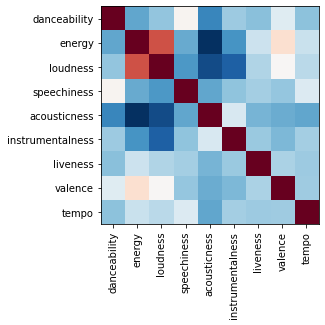

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

features = data_2017[['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness', 'valence', 'tempo']]
features_np = features.to_numpy(dtype=np.float64).T
features_np.shape

correlation_matrix = np.corrcoef(features_np)

names = ['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness', 'valence', 'tempo']
positions = [0,1,2,3,4,5,6,7,8]

plt.xticks(positions, names, rotation=90)
plt.yticks(positions,names,rotation=0)

# Show the correlation matrix

plt.imshow(correlation_matrix,cmap=plt.get_cmap('RdBu_r'))

From this matrix, we can see meaningful relationships between audio features.
1. Any feature has the maximum positive correlation with itself. This is obvious.
1. Loudness and energy correlate strongly. This makes sense, as loud music is generally energetic.
1. Energy and acousticness are negatively correlated. This also makes sense, as acoustic music is generally more calm.
1. Certain features are harder to correlate; for example, valence does not correlate strongly with any other audio feature.

TODO: move these import statements to their relevant location

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import metrics
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor


We need to extract the data from the zip file in order to use it. To do this, we create an empty pandas dataframe and iterate throught the files in the zip. We use the zipfile module to open each file, and we use pandas to concatenate it to the dataframe. 

In [ ]:
import zipfile
zipped = zipfile.ZipFile('/content/data_peak1-20220512T220913Z-001.zip')
dataframe = pd.DataFrame([])
for file in zipped.namelist():
    f = zipped.open(file)
    dataframe = pd.concat([dataframe, pd.read_csv(f)])

Because of how files are stored within a zipped folder, the files and thus the data are no longer in chonological order, but we won't worry about this now. We also need to use the reset_index method on the dataframe to fix our indexing after concatenation. 

In [ ]:
dataframe.reset_index();

##ADAM

In [ ]:
print(sp.search(q='artist:' + "adele", type='artist'))

{'artists': {'href': 'https://api.spotify.com/v1/search?query=artist%3Aadele&type=artist&offset=0&limit=10', 'items': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4dpARuHxo51G3z768sgnrY'}, 'followers': {'href': None, 'total': 37710878}, 'genres': ['british soul', 'pop', 'pop soul', 'uk pop'], 'href': 'https://api.spotify.com/v1/artists/4dpARuHxo51G3z768sgnrY', 'id': '4dpARuHxo51G3z768sgnrY', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab6761610000e5eb68f6e5892075d7f22615bd17', 'width': 640}, {'height': 320, 'url': 'https://i.scdn.co/image/ab6761610000517468f6e5892075d7f22615bd17', 'width': 320}, {'height': 160, 'url': 'https://i.scdn.co/image/ab6761610000f17868f6e5892075d7f22615bd17', 'width': 160}], 'name': 'Adele', 'popularity': 87, 'type': 'artist', 'uri': 'spotify:artist:4dpARuHxo51G3z768sgnrY'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/19RHMn8FFkEFmhPwyDW2ZC'}, 'followers': {'href': None, 'total': 44779}, 'genres': ['cabaret'

##Audio Features and Time (BENJI)

In this section we'll explore the relationship between a song's audio features and the year in which it was released.

Let's start by making a copy of the main dataframe so we can manipulate it as we please. 

In [ ]:
data = data_peak1.copy()

NameError: ignored

Since songs can stay on the charts for multiple weeks, out data has some duplicate entries, which will give the impression that our models are more accurate than they actually are. We use the drop_duplicates method to get rid of all but the first row containing any given song. 

In [ ]:
data = data.drop_duplicates(subset='song', keep="first")

Let's also add a new column to the dataframe which isolates the year from the rest of the date. We do this by converting the date column to a pandas Datetime object, extracting the year, and saving it in a new column called 'year'.

Why we do this will become clear later on, but essentially it makes graphing and modeling the data a bit simpler.

In [ ]:
data['year'] = pd.DatetimeIndex(pd.to_datetime(data['date'])).year

Some of the rows are missing data for all of the audio features, which will present problems when we try to graph. To prevent errors, we use the dropna method to drop any rows with missing values for the danceability column, which will coincide directly with rows missing data for all audio features. 

In [ ]:
data = data.dropna(subset=['danceability'])

If we take a peek at the first and last entries in our dataframe, we can see that the audio features of "When I Was Your Man (2013) are vastly different from the audio features of "The Tide is High" (1981). 

In [ ]:
data.head(1)

,Unnamed: 0,date,rank,song,artist,last-week,peak-rank,weeks-on-board,year,uri,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,43032,2013-08-10,33,When I Was Your Man,Bruno Mars,31.0,1,32,2013,spotify:track:0nJW01T7XtvILxQgC5J7Wh,0.612,0.28,-8.648,0.0434,0.932,0.0,0.088,0.387,72.795


In [ ]:
data.tail(1)

,Unnamed: 0,date,rank,song,artist,last-week,peak-rank,weeks-on-board,year,uri,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
999,212026,1981-03-21,27,The Tide Is High,Blondie,15.0,1,19,1981,spotify:track:3lGBRoe3c6oV398Xwgf7c7,0.777,0.8,-5.803,0.0276,0.181,0.00204,0.201,0.969,96.674


Naturally, we wonder if there have been clear upward or downward trends in some or all of these audio features as popular music has evolved over time. If so, can we use these audio features to predict the year in which a song was released?

To test this, let's create a linear regression model with terms for each of the audio features, and then analyze its ability to predict a song's release year.

We set our X to be the audio features and our Y to be the year. We then split our data into 70% training data and 30% test data so we can test the performance of our model. We use the stratify parameter on Y to make sure our sample split has an equal proportion of entries from each year. We create the model using the training data.


In [ ]:
X = data[['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness', 'valence', 'tempo']]
Y = data['year']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

LinearRegression()

Let's see what happens when we use this model to predict the year of a song. Since it's the first song in the dataframe, we'll use "When I Was Your Man" by Bruno Mars.

In [ ]:
regr.predict(data.head(1)[['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness', 'valence', 'tempo']])[0]

1998.2869743049728

"When I Was Your Man" was released in 2012, so this is not a great prediction, but it could be a lot worse.

With that said, one example is obviously not enough, so let's use the model to make predictions on the entire test data. 

In [ ]:
Y_pred = regr.predict(X_test)

One way to measure the accuracy of our prediction is the mean squared error. This squares the difference between each prediciton and the associated actual value, sums the squared differences, and then divides by the number of predictions. We can use sklearn's mean_squared_error to calculate this. 

In [ ]:
mean_squared_error(Y_test,Y_pred)

120.41245286991732

Our model can predict a song's year within roughly 11 years (square root of ~121) based on its audio features. This is decent, but can we make it better? Let's take a closer look at the audio features and see if we can create a more effective model. 

First, let's look at the linear regression model's coefficients for each audio feature to see which are most significant.

In [ ]:
print('Danceability Coefficient: ', regr.coef_[0])
print('Energy Coefficient: ', regr.coef_[1])
print('Loudness Coefficient: ', regr.coef_[2])
print('Speechiness Coefficient: ', regr.coef_[3])
print('Acousticness Coefficient: ', regr.coef_[4])
print('Instrumentalness Coefficient: ', regr.coef_[5])
print('Liveness Coefficient: ', regr.coef_[6])
print('Valence Coefficient: ', regr.coef_[7])
print('Tempo Coefficient: ', regr.coef_[8])

Danceability Coefficient:  21.920372730510753
Energy Coefficient:  -22.02171517140404
Loudness Coefficient:  3.0497097725956746
Speechiness Coefficient:  32.65708409650382
Acousticness Coefficient:  -5.049945066360155
Instrumentalness Coefficient:  -14.358661458553645
Liveness Coefficient:  0.06809687990430732
Valence Coefficient:  -14.725429469947404
Tempo Coefficient:  0.03421208692171618


We can see that danceability, energy, and speechiness are by far the most influential factors in our model. Loudness, liveness, and tempo, on the other hand, are mostly insignificant. 

Next, let's graph the features' per-year averages over time to get a better idea of their trends. We create a separate graph for loudness because it is not on a 0 to 1 scale, so its presence would throw off the scale of the graph. We omit tempo for the same reason, and because its coefficient is so low that we know it's mostly independent of time anyway.

We sort the dataframe by year so we can plot the features in order with respect to time. For each feature, we plot year on the x axis, and on the y axis, we group the data by year and find the average for that feature for each year. We plot danceability in blue, energy in green, speechiness in red, acousticness in cyan, instrumentalness in magenta, liveness in yellow, and valence in black. We use matplotlib's subplots to plot loudness over time adjacently. 

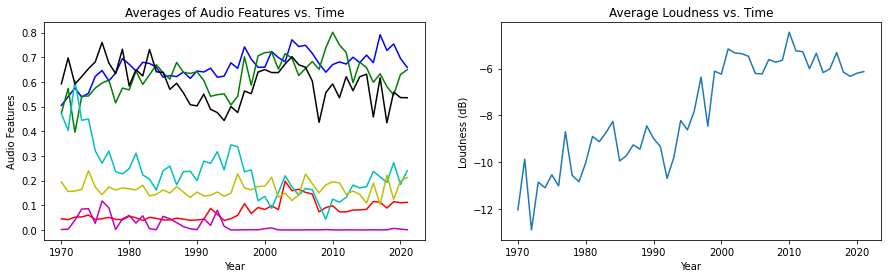

In [ ]:
data = data.sort_values(by=['year'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.plot(pd.unique(data['year']), data.groupby(['year'])['danceability'].mean(), 'b')
ax1.plot(pd.unique(data['year']), data.groupby(['year'])['energy'].mean(), 'g')
ax1.plot(pd.unique(data['year']), data.groupby(['year'])['speechiness'].mean(), 'r')
ax1.plot(pd.unique(data['year']), data.groupby(['year'])['acousticness'].mean(), 'c')
ax1.plot(pd.unique(data['year']), data.groupby(['year'])['instrumentalness'].mean(), 'm')
ax1.plot(pd.unique(data['year']), data.groupby(['year'])['liveness'].mean(), 'y')
ax1.plot(pd.unique(data['year']), data.groupby(['year'])['valence'].mean(), 'k')
ax1.set_title('Averages of Audio Features vs. Time')
ax1.set(xlabel='Year', ylabel='Audio Features')
ax2.plot(pd.unique(data['year']), data.groupby(['year'])['loudness'].mean())
ax2.set_title('Average Loudness vs. Time')
ax2.set(xlabel='Year', ylabel='Loudness (dB)')
plt.show()

These graphs illustrate the problem with our previous model: most of these features did not experience linear or strictly increasing/decreasing trends, so we can't expect a linear regression to effectively model the data and make accurate predictions. Specifically notice how valence (black) and acousticness (cyan) fluctuate significantly and irregularly over time. Also, notice that, as the coefficient indicates, liveness (yellow) shows no large scale pattern or trend.

Let's try a non-linear regression approach to see if we can better model this data. Let's also refrain from using the data for loudness, liveness, and tempo, because as we've seen, these features are largely independent of time. 

We'll use sklearn's decision tree regressor, using the same split between training and test data as before. Our input data will be limited to the features we've decided are significant: danceability, energy, speechiness, acousticness, instrumentalness, and valence. 

In [ ]:
X = data[['danceability','energy', 'speechiness', 'acousticness','instrumentalness','valence']]
Y = data['year']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)

We train the model using the test data.

In [ ]:
decision_tree = DecisionTreeRegressor(random_state=1)
decision_tree = decision_tree.fit(X_train, Y_train)

And again, we make predictions on the test data and view the mean squared error. 

In [ ]:
Y_pred_tree = decision_tree.predict(X_test)
mean_squared_error(Y_test, Y_pred_tree)

1.2082519641076344

The result is a mean squared error of 1.2, which is far better than our original linear regression model. We can successfully predict the year of a number 1 charting song within just over a year based on a selection of its audio features. This is illustrative of just how strong trends in music are, as well as how good Spotify's audio features are at quantifying sonic characteristics. 

##TANAYA

In this section, we can explore the various audio features as they relate to popularity in order to see if there are any meaningful correlations and if so, if it is possible to predict some level of popularity for a song based solely off of Spotify's audio features. The first step would be to import the neccessary libraries and datasets. The dataset used here is all the popular songs since 2017, including statistics about their popularity and audio features extracted using Spotify's API.



In [ ]:
import pandas as pd
pop_data = pd.read_csv("data_2017_full.csv")
pop_data.head()

,Unnamed: 0,date,rank,song,artist,last-week,peak-rank,weeks-on-board,uri,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,year
0,0,2021-11-06,1,Easy On Me,Adele,1.0,1,3,spotify:track:0gplL1WMoJ6iYaPgMCL0gX,0.604,0.366,-7.519,0.0282,0.5780,0.000000,0.1330,0.130,141.981,NaN
1,1,2021-11-06,2,Stay,The Kid LAROI & Justin Bieber,2.0,1,16,spotify:track:5HCyWlXZPP0y6Gqq8TgA20,0.591,0.764,-5.484,0.0483,0.0383,0.000000,0.1030,0.478,169.928,NaN
2,2,2021-11-06,3,Industry Baby,Lil Nas X & Jack Harlow,3.0,1,14,spotify:track:27NovPIUIRrOZoCHxABJwK,0.736,0.704,-7.409,0.0615,0.0203,0.000000,0.0501,0.894,149.995,NaN
3,3,2021-11-06,4,Fancy Like,Walker Hayes,4.0,3,19,spotify:track:58UKC45GPNTflCN6nwCUeF,0.647,0.765,-6.459,0.0600,0.1110,0.000000,0.3150,0.855,79.994,NaN
4,4,2021-11-06,5,Bad Habits,Ed Sheeran,5.0,2,18,spotify:track:3rmo8F54jFF8OgYsqTxm5d,0.807,0.893,-3.745,0.0347,0.0451,0.000028,0.3660,0.537,126.011,NaN


Looking at the dataset, it looks like one measure of popularity we can use here is peak rank. We can generate some graphs to see if a pattern emerges between peak rank and the audio features. 

---

